Lorenzo Zullo 
Real Estate Dataset 

The problem: Real estate investors need reliable data to decide where to invest in real estate.
They want to know which areas are growing and which properties are undervalued to maximize their return on investment (ROI)

The solution: 
Identify the best real estate markets with the highest growth potential.
Predict home prices based on key factors (house size, bedrooms, ZHVI trends).
Find undervalued properties by comparing current listings to long-term market trends.
Assess market risks by measuring price volatility in different states.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

First we have to import both data sets, we only need certain data points from each dataset so we input which columns we need. 

In [2]:

# File paths 
realtor_file = "Data/realtor-data.csv"
zhvi_file = "Data/zillow-zhvi.csv"

# Load realtor data 
# turn zip_code into string instead of float
realtor_df = pd.read_csv(realtor_file, usecols=["price", "bed", "bath", "acre_lot", "city", "state", "zip_code", "house_size"], 
                             dtype={"zip_code": "str"} )

# Load ZHVI data 
# only use certain columns
zhvi_df = pd.read_csv(zhvi_file, usecols=["RegionName", "StateName", "2020-01-31", "2025-01-31"])
# Rename columns for clarity
zhvi_df.rename(columns={"RegionName": "city", "StateName": "state", "2025-01-31": "ZHVI_latest", "2020-01-31": "ZHVI_2020"}, inplace=True)

realtor_df.head(), zhvi_df.head()


(      price  bed  bath  acre_lot        city        state zip_code  house_size
 0  105000.0  3.0   2.0      0.12    Adjuntas  Puerto Rico    00601       920.0
 1   80000.0  4.0   2.0      0.08    Adjuntas  Puerto Rico    00601      1527.0
 2   67000.0  2.0   1.0      0.15  Juana Diaz  Puerto Rico    00795       748.0
 3  145000.0  4.0   2.0      0.10       Ponce  Puerto Rico    00731      1800.0
 4   65000.0  6.0   2.0      0.05    Mayaguez  Puerto Rico    00680         NaN,
               city state      ZHVI_2020    ZHVI_latest
 0    United States   NaN  243005.332995  355327.955070
 1     New York, NY    NY  497295.221753  675063.976036
 2  Los Angeles, CA    CA  659455.738592  950740.494586
 3      Chicago, IL    IL  234666.174870  322389.516129
 4       Dallas, TX    TX  254715.294046  368515.900537)

We next have to make the data match on both sets so we can merge the two for our purposes. We can do this by making the cities and states the same. 

In [3]:
# Standardize city and state names
realtor_df["city"] = realtor_df["city"].str.strip().str.lower()
realtor_df["state"] = realtor_df["state"].str.strip().str.lower()

zhvi_df["city"] = zhvi_df["city"].str.split(",").str[0].str.strip().str.lower()
zhvi_df["state"] = zhvi_df["state"].str.strip()

# ChatGPT prompt: "Can you give me state names in lowercase followed by abbreviated state names in uppercase? Put them in a python dictionary."
# State abbreviations 
state_abbrev = {
    "alabama": "AL", "alaska": "AK", "arizona": "AZ", "arkansas": "AR", "california": "CA",
    "colorado": "CO", "connecticut": "CT", "delaware": "DE", "florida": "FL", "georgia": "GA",
    "hawaii": "HI", "idaho": "ID", "illinois": "IL", "indiana": "IN", "iowa": "IA",
    "kansas": "KS", "kentucky": "KY", "louisiana": "LA", "maine": "ME", "maryland": "MD",
    "massachusetts": "MA", "michigan": "MI", "minnesota": "MN", "mississippi": "MS",
    "missouri": "MO", "montana": "MT", "nebraska": "NE", "nevada": "NV", "new hampshire": "NH",
    "new jersey": "NJ", "new mexico": "NM", "new york": "NY", "north carolina": "NC",
    "north dakota": "ND", "ohio": "OH", "oklahoma": "OK", "oregon": "OR", "pennsylvania": "PA",
    "rhode island": "RI", "south carolina": "SC", "south dakota": "SD", "tennessee": "TN",
    "texas": "TX", "utah": "UT", "vermont": "VT", "virginia": "VA", "washington": "WA",
    "west virginia": "WV", "wisconsin": "WI", "wyoming": "WY", "district of columbia": "DC",
    "puerto rico": "PR"  
}

# Apply state abbreviation conversion to realtor dataset
realtor_df["state"] = realtor_df["state"].str.lower().map(state_abbrev)

# remove rows with missing values
zhvi_df = zhvi_df.dropna()

# remove united states from zhvi dataset
zhvi_df = zhvi_df[zhvi_df["city"] != "united states"]

# Display fixed head of datasets
realtor_df.head(), zhvi_df.head()


(      price  bed  bath  acre_lot        city state zip_code  house_size
 0  105000.0  3.0   2.0      0.12    adjuntas    PR    00601       920.0
 1   80000.0  4.0   2.0      0.08    adjuntas    PR    00601      1527.0
 2   67000.0  2.0   1.0      0.15  juana diaz    PR    00795       748.0
 3  145000.0  4.0   2.0      0.10       ponce    PR    00731      1800.0
 4   65000.0  6.0   2.0      0.05    mayaguez    PR    00680         NaN,
           city state      ZHVI_2020    ZHVI_latest
 1     new york    NY  497295.221753  675063.976036
 2  los angeles    CA  659455.738592  950740.494586
 3      chicago    IL  234666.174870  322389.516129
 4       dallas    TX  254715.294046  368515.900537
 5      houston    TX  222469.171285  305480.078502)

In [4]:

# Compute growth rate (2020-2025) in home values
zhvi_df["growth_2020_2025"] = ((zhvi_df["ZHVI_latest"] - zhvi_df["ZHVI_2020"]) / zhvi_df["ZHVI_2020"]) * 100
zhvi_df.drop(columns=["ZHVI_2020"], inplace=True)  # No longer needed


In [ ]:
# function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"Model": model_name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R² Score": r2}

Now we want to merge these datasets. We will do this on the state and city. We then drop values on cities we dont have to ensure
accurate insights. 

In [59]:


# Merge realtor dataset with Zillow ZHVI dataset on city and state
merged_df = realtor_df.merge(zhvi_df, on=["state", "city"], how="left")

# Drop rows where price and zhvi_latest are missing
merged_df.dropna(subset=["price"], inplace=True)
merged_df.dropna(subset=["ZHVI_latest"], inplace=True)

# remove outliers
merged_df = merged_df[merged_df["price"] < merged_df["price"].quantile(0.95)]
merged_df = merged_df[merged_df["price"] > merged_df["price"].quantile(0.01)]

# Target Encoding: Replace 'state' and 'zip_code' with their mean home price
state_avg_price = merged_df.groupby("state")["price"].transform("mean")
zip_avg_price = merged_df.groupby("zip_code")["price"].transform("mean")
    
# Add encoded features to the dataset
merged_df["state_encoded"] = state_avg_price
merged_df["zip_encoded"] = zip_avg_price

# Fill missing values in numeric columns with median values to avoid issues in analysis
for col in ["state_encoded", "zip_encoded", "bed", "bath", "house_size", "acre_lot", "ZHVI_latest", "growth_2020_2025"]:
    merged_df[col].fillna(merged_df[col].median(), inplace=True)


# Display merged dataset sample
print(merged_df.head(), merged_df.shape)

         price  bed  bath  acre_lot         city state zip_code  house_size  \
3464  184900.0  3.0   1.0      0.31  springfield    MA    01151      1252.0   
3473  279900.0  4.0   4.0      0.11  springfield    MA    01104      1908.0   
3704  750000.0  8.0   8.0      0.10  springfield    MA    01151     11890.0   
3738   42000.0  3.0   2.0      0.20  springfield    MA    01104      1625.0   
3775  240000.0  3.0   2.0      0.16  springfield    MA    01104      1284.0   

        ZHVI_latest  growth_2020_2025  state_encoded    zip_encoded  
3464  344466.768834         49.745212  536967.637828  260808.314286  
3473  344466.768834         49.745212  536967.637828  221187.222222  
3704  344466.768834         49.745212  536967.637828  260808.314286  
3738  344466.768834         49.745212  536967.637828  221187.222222  
3775  344466.768834         49.745212  536967.637828  221187.222222   (556348, 12)


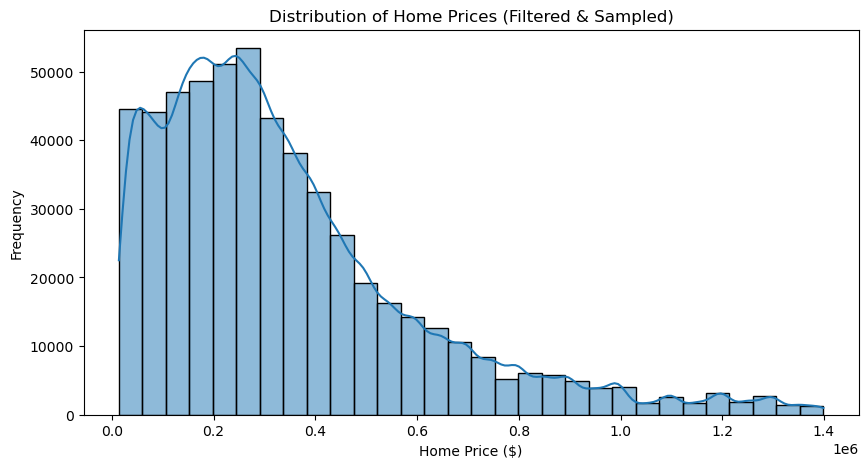

In [43]:
# Price Distribution Analysis

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(merged_df["price"], bins=30, kde=True)
plt.xlabel("Home Price ($)")
plt.ylabel("Frequency")
plt.title("Distribution of Home Prices (Filtered & Sampled)")
plt.show()


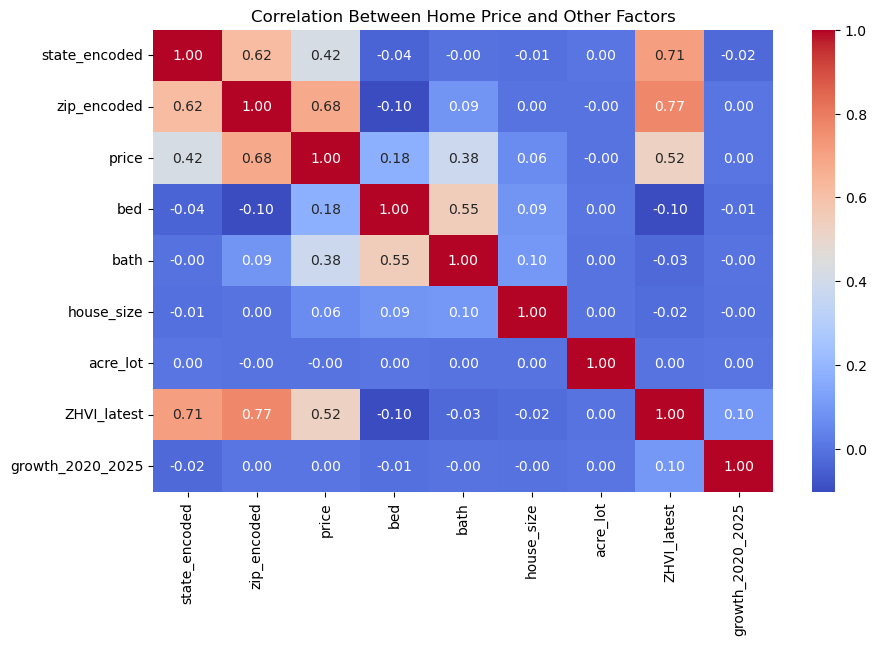

In [60]:
# Correlation matrix
correlation_matrix = merged_df[["state_encoded","zip_encoded", "price", "bed", "bath", "house_size", "acre_lot", "ZHVI_latest", "growth_2020_2025"]].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Home Price and Other Factors")
plt.show()

We will show the states with highest volatility to help us find states that have a wide range of home prices, which is an important insight for investors.

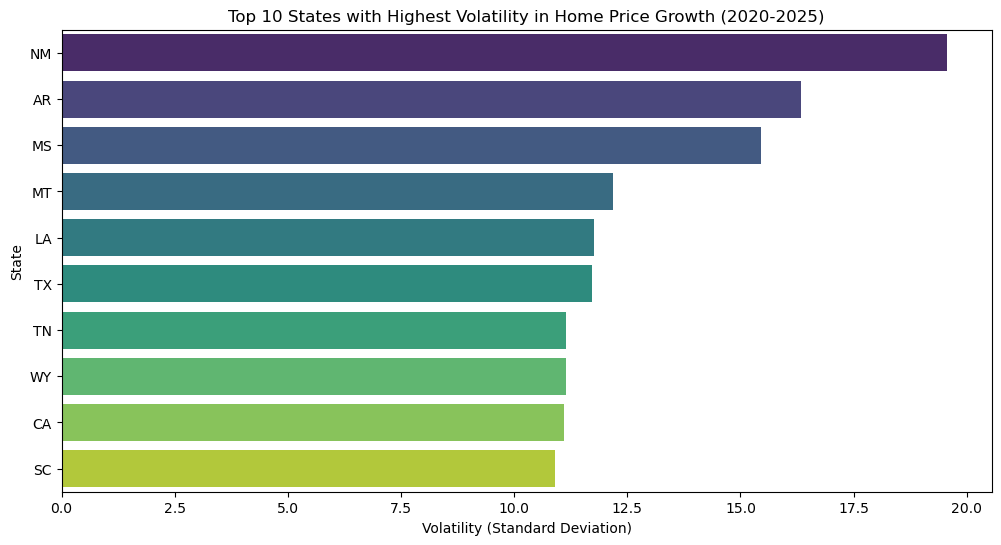

In [61]:
# Market Risk Assessment - Identify High-Volatility States
volatility_states = merged_df.groupby("state")["growth_2020_2025"].std().reset_index()
volatility_states = volatility_states.sort_values(by="growth_2020_2025", ascending=False).head(10)

# Visualization of High-Volatility States
plt.figure(figsize=(12, 6))
sns.barplot(data=volatility_states, x="growth_2020_2025", y="state", palette="viridis")
plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("State")
plt.title("Top 10 States with Highest Volatility in Home Price Growth (2020-2025)")
plt.show()


We will generate the top 10 states with highest home price growth to locate ideal states that would be attractive to investors. 

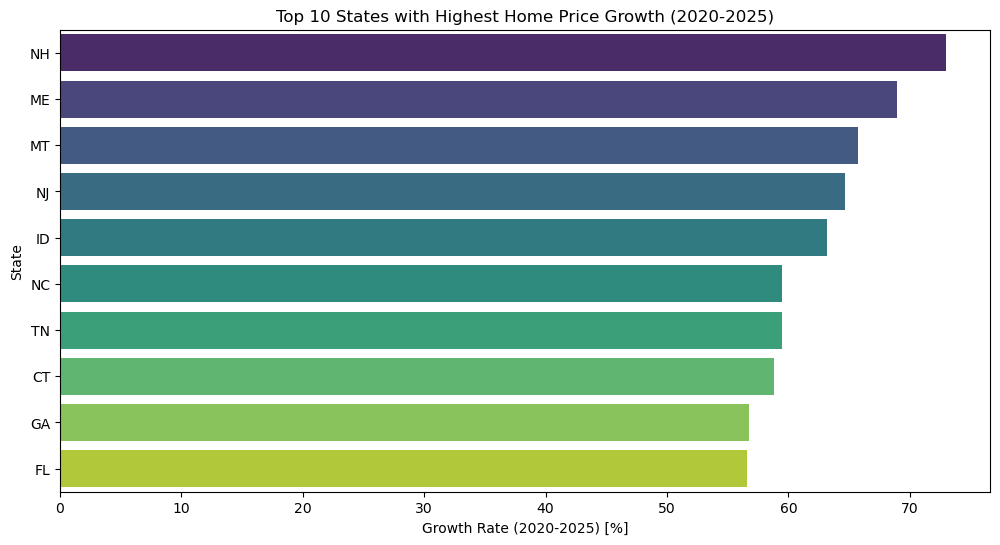

In [62]:
# Identify Top 10 States with Highest Home Price Growth
top_10_states = merged_df.groupby("state")["growth_2020_2025"].mean().reset_index()
top_10_states = top_10_states.sort_values(by="growth_2020_2025", ascending=False).head(10)

# Visualization of Top 10 Growth States
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_states, x="growth_2020_2025", y="state", palette="viridis")
plt.xlabel("Growth Rate (2020-2025) [%]")
plt.ylabel("State")
plt.title("Top 10 States with Highest Home Price Growth (2020-2025)")
plt.show()


In [ ]:
# Linear Regression Model to Predict Home Prices
# Prepare data for modeling
X = merged_df[["bed", "bath", "house_size", "acre_lot", "ZHVI_latest", "state_encoded", "zip_encoded"]]
y = merged_df["price"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [90]:

from sklearn.linear_model import LassoCV, RidgeCV

# Define feature set and target variable
features = ["bed", "bath", "house_size", "acre_lot", "ZHVI_latest", "growth_2020_2025", "state_encoded", "zip_encoded"]
target = "price"

X = merged_df[features]
y = merged_df[target]

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize feautures
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features] = scaler.fit_transform(X_train[features])
X_test_scaled[features] = scaler.transform(X_test[features])

# Train Lasso Regression Model with Cross-Validation for Best Alpha
lasso = LassoCV(alphas=np.logspace(-4, 2, 10), cv=5)
lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)

# Train Ridge Regression Model with Cross-Validation for Best Alpha
ridge = RidgeCV(alphas=np.logspace(-4, 2, 10), cv=5)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)

# Evaluate models
lasso_results = evaluate_model(y_test, lasso_pred, "Lasso Regression")
ridge_results = evaluate_model(y_test, ridge_pred, "Ridge Regression")
linear_result= evaluate_model(y_test, y_pred, "Linear Regression")

# Convert results to DataFrame
model_performance_df = pd.DataFrame([lasso_results, ridge_results, linear_result])

# Display model performance
print("\nModel Performance Comparison:")
print(model_performance_df)




Model Performance Comparison:
               Model            MAE           MSE           RMSE  R² Score
0   Lasso Regression  116221.724003  2.970146e+10  172341.122260  0.577715
1   Ridge Regression  116213.779770  2.969863e+10  172332.909807  0.577755
2  Linear Regression  116234.706811  2.970027e+10  172337.665446  0.577731


Now we want to find under valued markets to find where we should focus on investing in. We will indentify cities/states where home prices are much lower than expected compared to their historical ZHVI trends.

Areas with a low price-to-ZHVI ratio suggest properties are priced below market value, making them strong investment opportunities.

In [91]:
# Compute price-to-ZHVI ratio to find undervalued markets
merged_df["price_to_ZHVI_ratio"] = merged_df["price"] / merged_df["ZHVI_latest"]

# Group by state and city to find average price-to-ZHVI ratio
undervalued_markets = merged_df.groupby(["state", "city"])["price_to_ZHVI_ratio"].mean().reset_index()

# Sort by lowest price-to-ZHVI ratio (most undervalued)
undervalued_markets = undervalued_markets.sort_values(by="price_to_ZHVI_ratio")

# Display top 10 undervalued markets
print("\nTop 10 Undervalued Markets:")
print(undervalued_markets.head(10))


Top 10 Undervalued Markets:
    state        city  price_to_ZHVI_ratio
123    FL  north port             0.316493
378    MN    marshall             0.403954
682    SD    aberdeen             0.474913
498    NJ     trenton             0.479201
683    SD   brookings             0.485433
104    CT  bridgeport             0.489559
107    CT     norwich             0.510482
128    FL    palm bay             0.521689
94     CO     edwards             0.533479
112    FL   clewiston             0.534035


Now we will take a look at high growth markets, that have a relatebey low price.

If a city has high growth but still low home prices, it’s likely to appreciate soon, making it a strong investment choice.

In [92]:
# Find high-growth markets with relatively low prices
growth_vs_price = merged_df.groupby(["state", "city"]).agg(
    avg_growth=("growth_2020_2025", "mean"),
    avg_price=("price", "mean")
).reset_index()

# Sort by highest growth but lowest average price
best_growth_markets = growth_vs_price.sort_values(by=["avg_growth", "avg_price"], ascending=[False, True])

# Display top 10 best high-growth, low-price markets
print("\nTop 10 High-Growth, Low-Price Markets:")
print(best_growth_markets.head(10))


Top 10 High-Growth, Low-Price Markets:
    state               city  avg_growth     avg_price
167    GA          thomaston   87.235491  2.249927e+05
102    CO  steamboat springs   87.187038  7.713283e+05
491    NH             berlin   85.570898  1.360945e+05
434    MT          kalispell   85.483433  5.337461e+05
94     CO            edwards   84.245060  6.987955e+05
147    GA          cedartown   83.989344  2.157279e+05
170    GA             toccoa   82.139018  2.066706e+05
112    FL          clewiston   81.429850  1.469858e+05
494    NH            laconia   79.275613  4.471493e+05
866    WY            jackson   78.466808  1.015455e+06


Now we will combine these scores into one 'investment score'. This is used so we can see what the best possible city/state is according to our data. 

This ranking helps investors decide where to buy properties based on multiple factors:
- High growth rate (growth_2020_2025)
- Low price-to-ZHVI ratio (undervalued properties)
- Low price volatility 

In [95]:
# Normalize scores for fair comparison
merged_df["growth_score"] = merged_df["growth_2020_2025"] / merged_df["growth_2020_2025"].max()
merged_df["undervaluation_score"] = 1 - (merged_df["price_to_ZHVI_ratio"] / merged_df["price_to_ZHVI_ratio"].max())
merged_df["stability_score"] = 1 - (merged_df["price"].std() / merged_df["price"].max())  # Lower volatility is better

# Compute final investment score (weighted average)
merged_df["investment_score"] = (merged_df["growth_score"] * 0.5) + \
                                (merged_df["undervaluation_score"] * 0.3) + \
                                (merged_df["stability_score"] * 0.2)

# Rank markets from best to worst
top_investment_markets = merged_df.groupby(["state", "city"])["investment_score"].mean().reset_index()
top_investment_markets = top_investment_markets.sort_values(by="investment_score", ascending=False)

# Display top 10 best markets to invest in
print("\nTop 10 Markets to Invest In:")
print(top_investment_markets.head(10))


Top 10 Markets to Invest In:
    state               city  investment_score
102    CO  steamboat springs          0.946955
491    NH             berlin          0.940929
167    GA          thomaston          0.934493
434    MT          kalispell          0.934276
94     CO            edwards          0.933879
147    GA          cedartown          0.922067
112    FL          clewiston          0.917731
170    GA             toccoa          0.913007
334    ME            augusta          0.897331
866    WY            jackson          0.896957


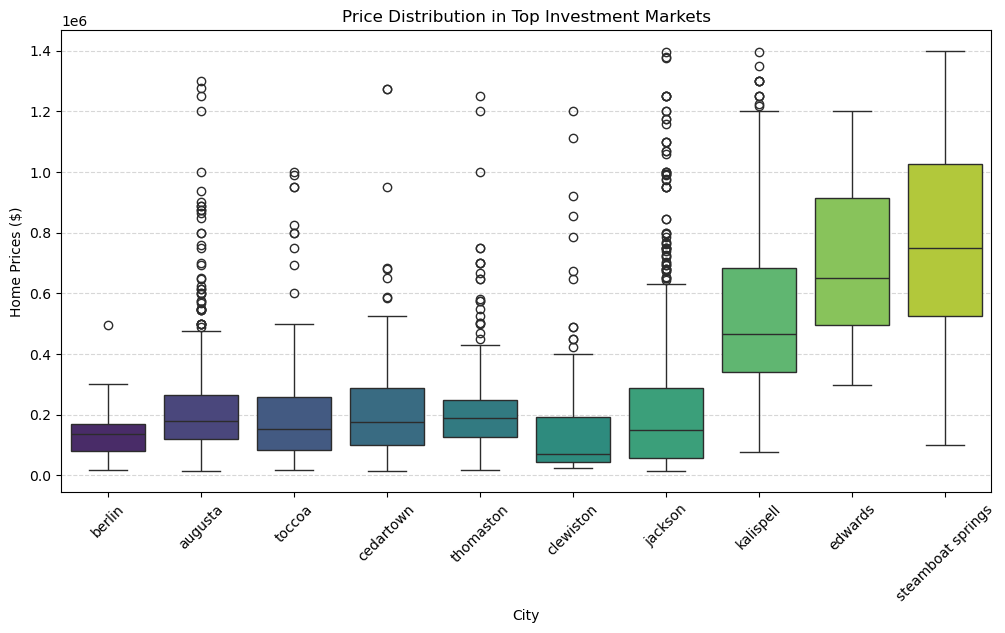

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure top 10 investment markets are available
top_10_investment_markets = top_investment_markets.head(10)

state_investment_scores = merged_df.groupby("state")["investment_score"].mean().reset_index()

# Box Plot: Price Distributions in Top Investment Cities
top_10_price_data = merged_df[merged_df["city"].isin(top_10_investment_markets["city"])]

plt.figure(figsize=(12, 6))
sns.boxplot(data=top_10_price_data, x="city", y="price", palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("City")
plt.ylabel("Home Prices ($)")
plt.title("Price Distribution in Top Investment Markets")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

In [ ]:
import plotly.express as px

# Create a choropleth map of investment scores
fig = px.choropleth(
    state_investment_scores,
    locations="state",
    locationmode="USA-states",
    color="investment_score",
    color_continuous_scale="Viridis",
    scope="usa",
    title="                                 Investment Score by State",
    labels={"investment_score": "Investment Score"}
)

fig.show()

In [ ]:
# %pip install geopy folium
import pandas as pd
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
import time

top100_markets_df = pd.DataFrame(top_investment_markets.head(100))  # use top 100 investment markets for heatmap

# this can be confusing, what we need to do is to get the coordinates of the cities so we can plot them on the map
# we will use the geopy library to get the coordinates of the cities
# we will use the Nominatim geocoder to get the coordinates
# we will then plot the coordinates on the map

# Geocode cities to get coordinates
geolocator = Nominatim(user_agent="city_locator")
latitudes = []
longitudes = []

# now we iterate through every row in the dataframe and get the coordinates
for index, row in df.iterrows():
    location = geolocator.geocode(f"{row['city']}, {row['state']}, USA", timeout=10)
    # 
    if location:
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
    else:
        latitudes.append(None)
        longitudes.append(None)

top100_markets_df['latitude'] = latitudes
top100_markets_df['longitude'] = longitudes

# Drop rows where geocoding failed
top100_markets_df.dropna(subset=['latitude', 'longitude'], inplace=True)

In [ ]:

# Center the map on the US
m = folium.Map(location=[37, -95], zoom_start=4)

# Create a list of coordinates and investment scores
heat_data = [[row['latitude'], row['longitude'], row['investment_score']] 
             for index, row in top100_markets_df.iterrows()]

# Add the HeatMap layer
HeatMap(heat_data, min_opacity=0.6, radius=20).add_to(m)

m

